In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    # Check if first class label is numeric or alphabetic
    if class_name == annotation_name:
        ## Convert to int type
        tmp_y_train = train_data[annotation_name].copy()
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_numpy()
    else:
        y_train = train_data[annotation_name].to_numpy()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
#                         callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

def joint_model(is_max, weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                pred_df, y_train_2, pred_df_test, y_test_2,
                class_weight_dict_1, class_weight_dict_2, joint_batch_size, joint_epochs):
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict_1, joint_batch_size, joint_epochs):
        joint_full_model_1 = models_nn.create_joint_model(pred_df_full)
        history_1 = joint_full_model_1.fit(x=pred_df_full, 
                                           y=y_train_1, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_full_test,y_test_1), 
                                           #callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict_1,
                                           verbose=0)
        joint_predict_1 = joint_full_model_1.predict(pred_df_full_test)
        # joint_predict_round = []
        # for a in joint_predict:
        #     joint_predict_round.append(np.argmax(a))
        joint_predict_round_1 = joint_predict_1.round()
        out1 = precision_recall_fscore_support(y_test_1, np.array(joint_predict_round_1), average='macro')

        val_f1_list = history_1.history['val_f1_m']
        
        # if is_max, then take max f1 from history, otherwise take last value
        if is_max == True:
            best_val_f1 = max(val_f1_list)
        else:
            best_val_f1 = val_f1_list[-1]
        
        best_val_prec = history_1.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history_1.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Deception", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    rapport_1, rapport_2 = helper("Rapport", pred_df, y_train_2, pred_df_test, y_test_2, class_weight_dict_2, joint_batch_size, joint_epochs)

    
    return decep_1, decep_2, rapport_1, rapport_2

In [7]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, class_name, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, class_name, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, class_name, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, class_name, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, class_name, 'Answer.1gamemove.yes_label')
        print("#############################################################")
        print("Class weights generated")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        _, _ = individual_model('Deception', X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model('Rapport', X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model('Share Info', X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model('Reasoning', X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model('Gamemove', X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
        
        ## Generate weighted one-hot encodings (HARD-CODED)
        pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)
        pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _, out2_wo_weights, _ = joint_model(False, None, pred_df_full, y_train_deception, pred_test_df_full, y_test_deception,
                                                       pred_df, y_train_rapport, pred_test_df, y_test_rapport,
                                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Throughput
        out1_tp, _, out2_tp, _ = joint_model(False, 'Throughput', pred_df_full_throughput, y_train_deception, pred_df_full_throughput_test, y_test_deception,
                                       pred_df_throughput, y_train_rapport, pred_df_throughput_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Worktime
        out1_wt, _, out2_wt, _ = joint_model(False, 'Worktime', pred_df_full_worktime, y_train_deception, pred_df_full_worktime_test, y_test_deception,
                                       pred_df_worktime, y_train_rapport, pred_df_worktime_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by PC Agreement
        out1_pc, _, out2_pc, _ = joint_model(False, 'PC Agreement', pred_df_full_agreement, y_train_deception, pred_df_full_agreement_test, y_test_deception,
                                       pred_df_agreement, y_train_rapport, pred_df_agreement_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Text Length
        out1_tl, _, out2_tl, _ = joint_model(False, 'Text Length', pred_df_full_textlength, y_train_deception, pred_df_full_textlength_test, y_test_deception,
                                       pred_df_textlength, y_train_rapport, pred_df_textlength_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Special options
        out1_sp, _, out2_sp, _ = joint_model(False, 'Special', pred_df_full_special, y_train_deception, pred_df_full_special_test, y_test_deception,
                                       pred_df_special, y_train_rapport, pred_df_special_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out2_wo_weights, out1_tp, out2_tp, out1_wt, out2_wt, 
                                                   out1_pc, out2_pc, out1_tl, out2_tl, out1_sp, out2_sp]
    print("Done")
    return results

In [8]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL2'
special_option = 'SP3'
k_option_for_tp = 3
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'lstm-attn'
indiv_batch_size = 128
indiv_epochs = 50

# Joint model options
joint_batch_size = 64
joint_epochs = 32

Full dataset proportions w.r.t. Input.deception_quadrant
Straightforward    10808
Cassandra            558
Name: Input.deception_quadrant, dtype: int64
#################################
Sample size: 250
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Deception: {

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#################################
Sample size: 500
#################################
#############################################################
Metadata options for current sample
TP3 + k: we

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.99454265832901, Precision = 0.9891493320465088, Recall = 1.0
Macro validation metrics: F1 = 0.4910941475826972, Precision = 0.4948717948717949, Recall = 0.48737373737373735
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.8948519229888916, Precision = 0.8098958730697632, Recall = 1.0
Macro validation metrics: F1 = 0.48333990104645563, Precision = 0.48288690476190477, Recall = 0.484745481677997
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.885656476020813, Precision = 0.7955728769302368, Recall = 1.0
Macro validation metrics: F1 = 0.494833524684271, Precision = 0.5068947906026557, Recall = 0.5039994074951859
#############################################################
Metrics for Reaso

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9916770458221436, Precision = 0.9835668206214905, Recall = 1.0
Macro validation metrics: F1 = 0.4959677419354839, Precision = 0.492, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9470322728157043, Precision = 0.9864304065704346, Recall = 0.9110243320465088
Macro validation metrics: F1 = 0.5106099757262549, Precision = 0.5151312009193642, Recall = 0.5802845528455285
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9916770458221436, Precision = 0.9835668206214905, Recall = 1.0
Macro validation metrics: F1 = 0.4959677419354839, Precision = 0.492, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.3850630819797516, Precision = 1.0, Recall = 0

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9984251856803894, Precision = 0.996874988079071, Recall = 1.0
Macro validation metrics: F1 = 0.49916527545909856, Precision = 0.49833333333333335, Recall = 0.5
#################################
Sample size: 1750
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#####

#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.89039146900177, Precision = 0.802734375, Recall = 1.0
Macro validation metrics: F1 = 0.45718038592442617, Precision = 0.4887637580122066, Recall = 0.48281250000000003
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9645735025405884, Precision = 0.931640625, Recall = 1.0
Macro validation metrics: F1 = 0.5285844007805406, Precision = 0.5259266497296593, Recall = 0.5382104454685099
#############################################################
Weighted one-hot encodings generated
#############################################################
Metrics for Deception joint model w/o weights:
Best validation metrics: F1 = 0.8043782114982605, Precision = 0.9778128266334534, Recall = 0.6852036714553833
Macro validation metrics: F1 = 0.42416725726435156, Precision = 0.504247833176006

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9910151958465576, Precision = 0.982421875, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.49, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.3795233368873596, Precision = 0.9754464626312256, Recall = 0.27653929591178894
Macro validation metrics: F1 = 0.16818174912260267, Precision = 0.49695945945945946, Recall = 0.47732426303854875
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9910151958465576, Precision = 0.982421875, Recall = 1.0
Macro validation metrics: F1 = 0.494949494949495, Precision = 0.49, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.9703888297080994, Precision = 0.981651246547699, Recal

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.987828254699707, Precision = 0.9759868383407593, Recall = 1.0
Macro validation metrics: F1 = 0.4907407407407407, Precision = 0.4880294659300184, Recall = 0.4934823091247672
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9364672899246216, Precision = 0.8810855150222778, Recall = 1.0
Macro validation metrics: F1 = 0.4961692205196536, Precision = 0.49707179897319476, Recall = 0.49658019223236616
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9160272479057312, Precision = 0.8463815450668335, Recall = 1.0
Macro validation metrics: F1 = 0.5138511500612187, Precision = 0.5135074178027266, Recall = 0.5147991543340381
#############################################################
Metrics for Re

Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.16689887642860413, Precision = 1.0, Recall = 0.0926547423005104
Macro validation metrics: F1 = 0.1089672729708907, Precision = 0.5119266055045871, Recall = 0.5468483816013628
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9896231889724731, Precision = 0.979687511920929, Recall = 1.0
Macro validation metrics: F1 = 0.4945240101095198, Precision = 0.4891666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.4833032488822937, Precision = 0.9636141657829285, Recall = 0.32815665006637573
Macro validation metrics: F1 = 0.25437688080995136, Precision = 0.4928506509299914, Recall = 0.42681168916262613
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9896231889724731, Precision = 0.979687511920929, Recall = 1.0
Mac

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9876822829246521, Precision = 0.9758522510528564, Recall = 1.0
Macro validation metrics: F1 = 0.4938539407086045, Precision = 0.4878571428571429, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.9517292380332947, Precision = 0.974114179611206, Recall = 0.9312214255332947
Macro validation metrics: F1 = 0.4760479041916168, Precision = 0.4869831546707504, Recall = 0.465592972181552
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9876822829246521, Precision = 0.9758522510528564, Recall = 1.0
Macro validation metrics: F1 = 0.4938539407086045, Precision = 0.4878571428571429, Recall = 0.5
#################################
Sample size: 4000
#################################
#############################################################
Metadata options for curren

#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.915064811706543, Precision = 0.8447265625, Recall = 1.0
Macro validation metrics: F1 = 0.4505494505494505, Precision = 0.510164982429669, Recall = 0.5207253886010363
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.882712185382843, Precision = 0.8112503290176392, Recall = 0.9695196747779846
Macro validation metrics: F1 = 0.5043603739255913, Precision = 0.5097821349425103, Recall = 0.5132646860510609
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9014260768890381, Precision = 0.8212890625, Recall = 1.0
Macro validation metrics: F1 = 0.4923670957472982, Precision = 0.5064684450153754, Recall = 0.5100091471995496
#############################################################
Metrics for Gam

Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.3351134657859802, Precision = 0.9748626351356506, Recall = 0.2030133157968521
Macro validation metrics: F1 = 0.19770986383754555, Precision = 0.5027411907955325, Recall = 0.5157498490713448
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9855301380157471, Precision = 0.9716796875, Recall = 1.0
Macro validation metrics: F1 = 0.4926433282597666, Precision = 0.4855, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.939279317855835, Precision = 0.9722312688827515, Recall = 0.9095426797866821
Macro validation metrics: F1 = 0.49419200471501024, Precision = 0.5019871672093469, Recall = 0.5058950957065237
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9855301380157471, Precision = 0.9716796875, Recall = 1.0
Macro validat

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9856542944908142, Precision = 0.9719328284263611, Recall = 1.0
Macro validation metrics: F1 = 0.4935543278084714, Precision = 0.48727272727272725, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.7820022106170654, Precision = 0.97817462682724, Recall = 0.6546064019203186
Macro validation metrics: F1 = 0.41980297645130404, Precision = 0.5043395596580601, Recall = 0.5398454157782516
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9856542944908142, Precision = 0.9719328284263611, Recall = 1.0
Macro validation metrics: F1 = 0.4935543278084714, Precision = 0.48727272727272725, Recall = 0.5
#################################
Sample size: 6000
#################################
#############################################################
Metadata options for cur

#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.8440603613853455, Precision = 0.8817318081855774, Recall = 0.8102399706840515
Macro validation metrics: F1 = 0.4836426188385041, Precision = 0.49433333333333335, Recall = 0.4908272226448894
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9112724661827087, Precision = 0.8372159600257874, Recall = 1.0
Macro validation metrics: F1 = 0.4998095238095238, Precision = 0.502182429806247, Recall = 0.5027404537621312
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9069383144378662, Precision = 0.8301136493682861, Recall = 1.0
Macro validation metrics: F1 = 0.5001007123107066, Precision = 0.5053308823529412, Recall = 0.5072448380528873
#############################################################


Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.5844632983207703, Precision = 0.9715473651885986, Recall = 0.4210312068462372
Macro validation metrics: F1 = 0.32129879334628914, Precision = 0.5006382088302992, Recall = 0.5057461519621695
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9858292937278748, Precision = 0.9721996784210205, Recall = 1.0
Macro validation metrics: F1 = 0.49293734154291924, Precision = 0.4860714285714286, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.08370481431484222, Precision = 0.9715909361839294, Recall = 0.04443894326686859
Macro validation metrics: F1 = 0.06903444858331662, Precision = 0.49769757461786973, Recall = 0.4964015900827069
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9858292937278748, Precision = 0.972199678421020

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9787330031394958, Precision = 0.9586123824119568, Recall = 1.0
Macro validation metrics: F1 = 0.48962232051718274, Precision = 0.4796666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.7057880759239197, Precision = 0.9545028209686279, Recall = 0.5631228089332581
Macro validation metrics: F1 = 0.38545040064964925, Precision = 0.49507204480780526, Recall = 0.4689276478428781
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9787330031394958, Precision = 0.9586123824119568, Recall = 1.0
Macro validation metrics: F1 = 0.48962232051718274, Precision = 0.4796666666666667, Recall = 0.5
#################################
Sample size: 8000
#################################
#############################################################
Metadata options for 

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.980979859828949, Precision = 0.9628596305847168, Recall = 1.0
Macro validation metrics: F1 = 0.514643345504816, Precision = 0.5156477651350918, Recall = 0.538260238386308
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9258559346199036, Precision = 0.8624752163887024, Recall = 1.0
Macro validation metrics: F1 = 0.4780132536683134, Precision = 0.49591871584699454, Recall = 0.4928254944104898
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9030736684799194, Precision = 0.8237847089767456, Recall = 1.0
Macro validation metrics: F1 = 0.4858398879597148, Precision = 0.49540215432331614, Recall = 0.49352100564387147
#############################################################
Metrics for Rea

Metrics for Rapport joint model w/o weights:
Best validation metrics: F1 = 0.9771629571914673, Precision = 0.9558189511299133, Recall = 1.0
Macro validation metrics: F1 = 0.48936170212765956, Precision = 0.4791666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.8625486493110657, Precision = 0.951458752155304, Recall = 0.7904373407363892
Macro validation metrics: F1 = 0.4581534745604558, Precision = 0.49259928345882925, Recall = 0.4698550724637681
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9771629571914673, Precision = 0.9558189511299133, Recall = 1.0
Macro validation metrics: F1 = 0.48936170212765956, Precision = 0.4791666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.8701872229576111, Precision

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.33485445380210876, Precision = 0.941623866558075, Recall = 0.20643547177314758
Macro validation metrics: F1 = 0.2199726911055566, Precision = 0.49912710442267094, Recall = 0.49723745074524583
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9714508652687073, Precision = 0.944886326789856, Recall = 1.0
Macro validation metrics: F1 = 0.48593073593073594, Precision = 0.4726315789473684, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.4910978376865387, Precision = 0.9406894445419312, Recall = 0.3344477713108063
Macro validation metrics: F1 = 0.2956215605288295, Precision = 0.49748176266669647, Recall = 0.4891532465307521
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9714508652687073, Precision = 0.944886326789856, 

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.973686695098877, Precision = 0.9490243196487427, Recall = 1.0
Macro validation metrics: F1 = 0.5171868640380985, Precision = 0.5166085132546765, Recall = 0.5305109326193663
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9225695133209229, Precision = 0.8569712042808533, Recall = 1.0
Macro validation metrics: F1 = 0.4827131293682199, Precision = 0.4979970964021216, Recall = 0.49667774086378735
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9142934083938599, Precision = 0.8427248597145081, Recall = 1.0
Macro validation metrics: F1 = 0.49822537710736475, Precision = 0.5117781348841954, Recall = 0.5188798179141907
#############################################################
Metrics for Re

Metrics for Rapport joint model w/o weights:
Best validation metrics: F1 = 0.974777102470398, Precision = 0.9513393044471741, Recall = 1.0
Macro validation metrics: F1 = 0.4878957169459963, Precision = 0.4763636363636364, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.6395971775054932, Precision = 0.9469945430755615, Recall = 0.48692044615745544
Macro validation metrics: F1 = 0.3598083618703947, Precision = 0.49589404587022407, Recall = 0.4772276864357017
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.974777102470398, Precision = 0.9513393044471741, Recall = 1.0
Macro validation metrics: F1 = 0.4878957169459963, Precision = 0.4763636363636364, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.0525781586766243, Precision =

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.7403755187988281, Precision = 0.9524632692337036, Recall = 0.6085806488990784
Macro validation metrics: F1 = 0.4175945908521367, Precision = 0.5019987659933753, Recall = 0.510167503634201
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9745005369186401, Precision = 0.9506229758262634, Recall = 1.0
Macro validation metrics: F1 = 0.4873760144274121, Precision = 0.47537379067722074, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.9745005369186401, Precision = 0.9506229758262634, Recall = 1.0
Macro validation metrics: F1 = 0.4873760144274121, Precision = 0.47537379067722074, Recall = 0.5
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9745005369186401, Precision = 0.9506229758262634, Recall = 1.0
Macro validation me

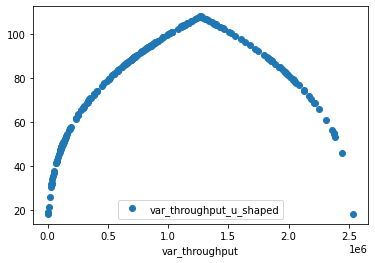

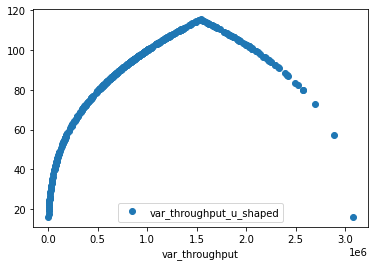

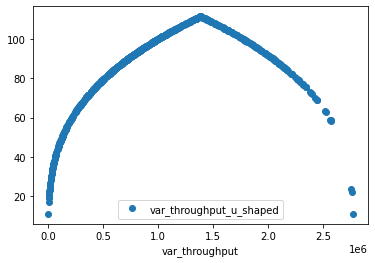

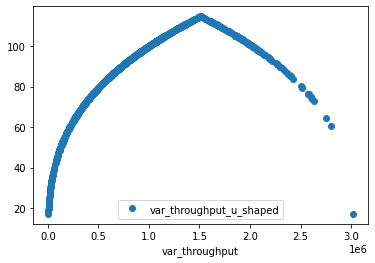

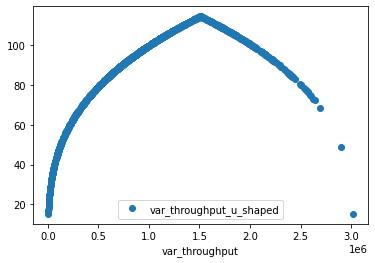

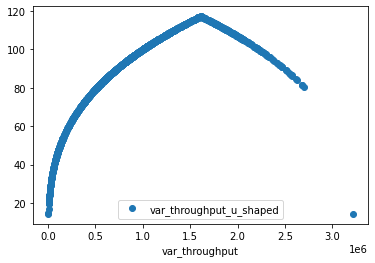

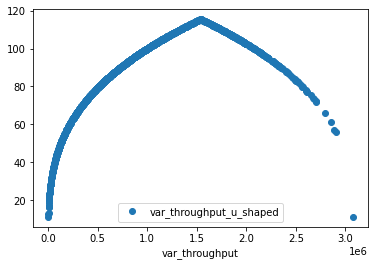

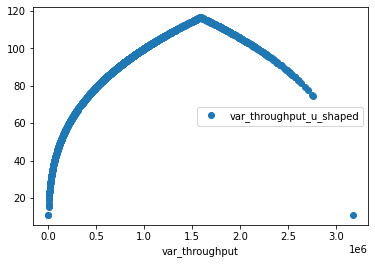

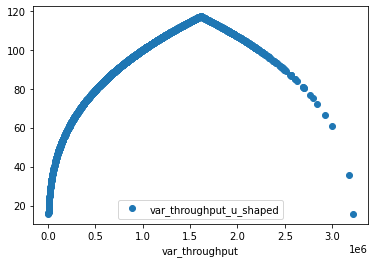

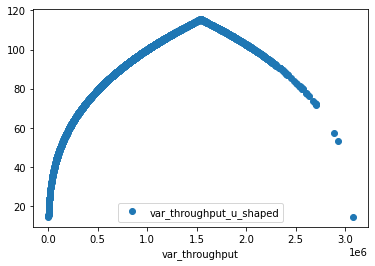

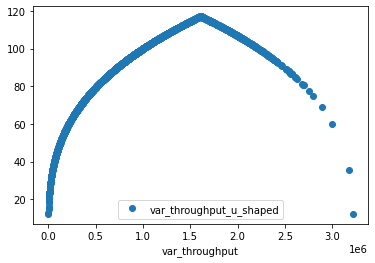

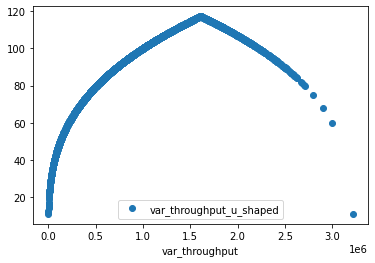

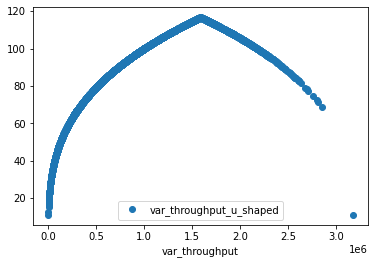

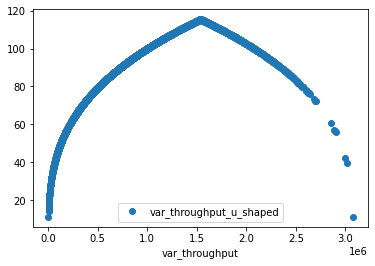

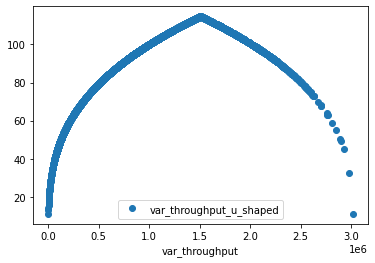

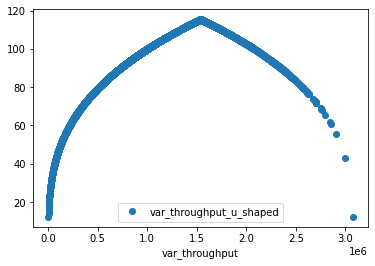

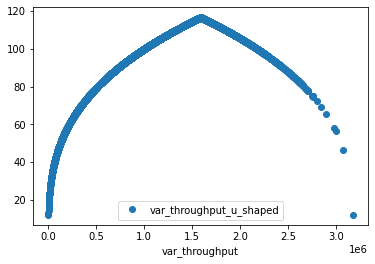

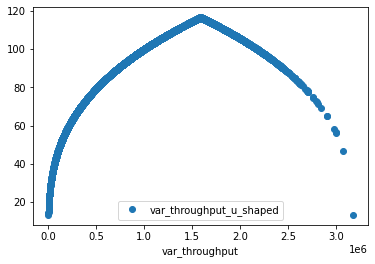

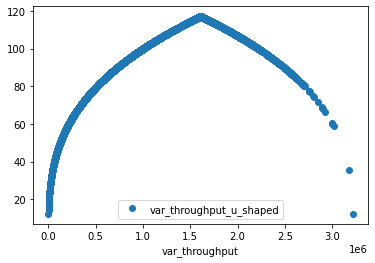

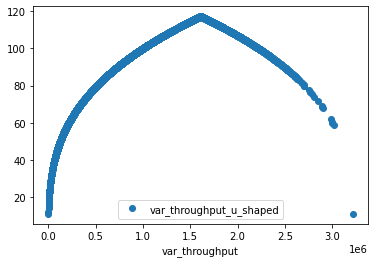

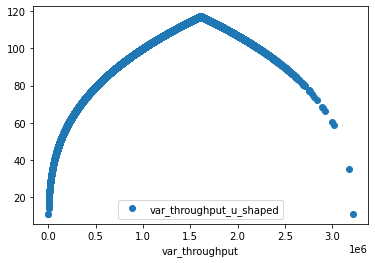

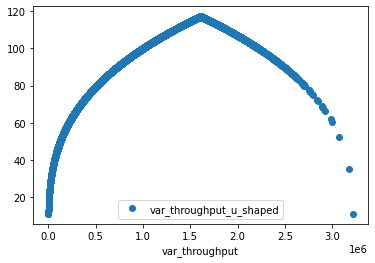

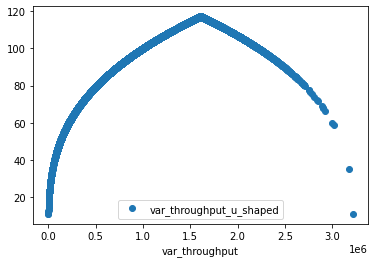

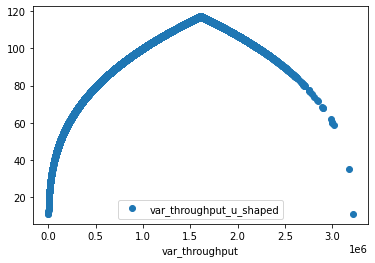

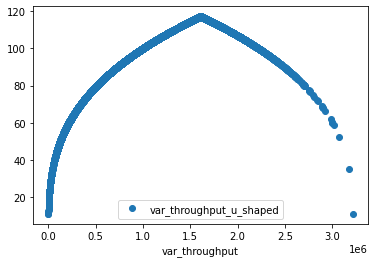

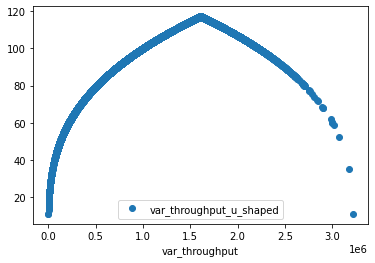

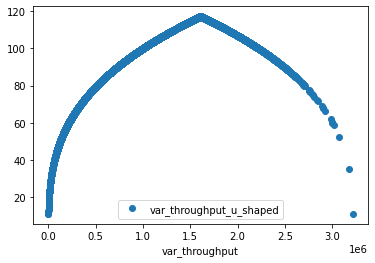

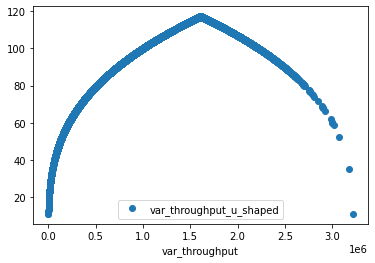

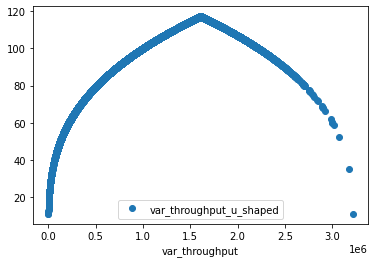

In [9]:
sampling_sizes = [250, 500, 750, 
                  1000, 1250, 1500, 1750, 
                  2000, 2250, 2500, 2750,
                  3000, 3500, 
                  4000, 4500, 
                  5000, 5500, 
                  6000, 6500, 
                  7000, 7500, 
                  8000, 8500, 
                  9000, 9500, 
                  10000, 10500, 11000, 11366]
# sampling_sizes = [11366]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="Input.deception_quadrant", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name)

In [10]:
def translate_into_pandas(results_dictionary, metric_of_focus):
    def helper(metric_of_focus_number):
        new_dict = {}
        for each_key, each_values_list in results_dictionary.items():
            new_dict[each_key[4:]] = []
            for each in each_values_list:
                new_dict[each_key[4:]].append(each[metric_of_focus_number])
        out_df = pd.DataFrame.from_dict(new_dict)
        return out_df
    
    if metric_of_focus == 'F1':
        metric_of_focus_number = 0
    elif metric_of_focus == 'Precision':
        metric_of_focus_number = 1
    elif metric_of_focus == 'Recall':
        metric_of_focus_number = 2
        
    return helper(metric_of_focus_number)

experiment_df = translate_into_pandas(results_dict, 'Precision')
results_name = "./output/dataset_sampling_" + str(len(sampling_sizes)) + "pts_last"
experiment_df.to_csv(results_name + ".csv", index=False)
experiment_df

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,0.994444,0.992188,0.983354,0.995918,0.979701,0.977813,0.846842,0.969135,...,0.969345,0.958612,0.957586,0.948778,0.967351,0.949700,0.948353,0.000000,0.950750,0.950621
1,0.0,0.0,0.994792,0.992188,0.983567,0.996875,0.978819,0.977679,0.982422,0.968299,...,0.972200,0.958612,0.959375,0.962513,0.955819,0.944886,0.949707,0.948645,0.951339,0.950623
2,0.0,0.0,1.000000,0.992188,0.987324,0.000000,1.000000,0.964550,0.979802,0.966880,...,0.971547,0.951329,0.560000,0.978927,0.951459,0.951452,0.951141,0.959393,0.946995,0.950066
3,0.0,0.0,0.994792,0.992188,0.983567,0.996875,0.978819,0.977679,0.982422,0.968299,...,0.972200,0.958612,0.959375,0.962513,0.955819,0.944886,0.949707,0.948645,0.951339,0.950623
4,0.0,0.0,0.666667,0.992188,0.986430,0.987500,0.978819,0.982263,0.866667,0.250000,...,0.971591,0.989583,0.941286,0.962513,0.957067,0.000000,0.725521,0.945991,0.754762,0.944996
5,0.0,0.0,0.994792,0.992188,0.983567,0.996875,0.978819,0.977679,0.982422,0.968299,...,0.972200,0.958612,0.959375,0.962513,0.955819,0.944886,0.949707,0.948645,0.951339,0.950623
6,0.0,0.0,0.982456,0.992188,1.000000,0.996875,0.978408,0.981172,0.975446,0.959181,...,0.975761,0.958564,0.951189,0.964218,0.939825,0.783333,0.949307,0.942254,0.950663,0.948653
7,0.0,0.0,0.994792,0.992188,0.983567,0.996875,0.978819,0.977679,0.982422,0.968299,...,0.972200,0.958612,0.959375,0.962513,0.955819,0.944886,0.949707,0.948645,0.951339,0.950623
8,0.0,0.0,0.994048,0.994444,0.974960,0.995833,0.977954,0.970498,0.981651,0.967793,...,0.967247,0.958364,0.280000,0.955924,0.957734,0.941624,0.947753,0.945471,0.944898,0.952463
9,0.0,0.0,0.994792,0.992188,0.983567,0.996875,0.978819,0.977679,0.982422,0.968299,...,0.972200,0.958612,0.959375,0.962513,0.955819,0.944886,0.949707,0.948645,0.951339,0.950623


In [11]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

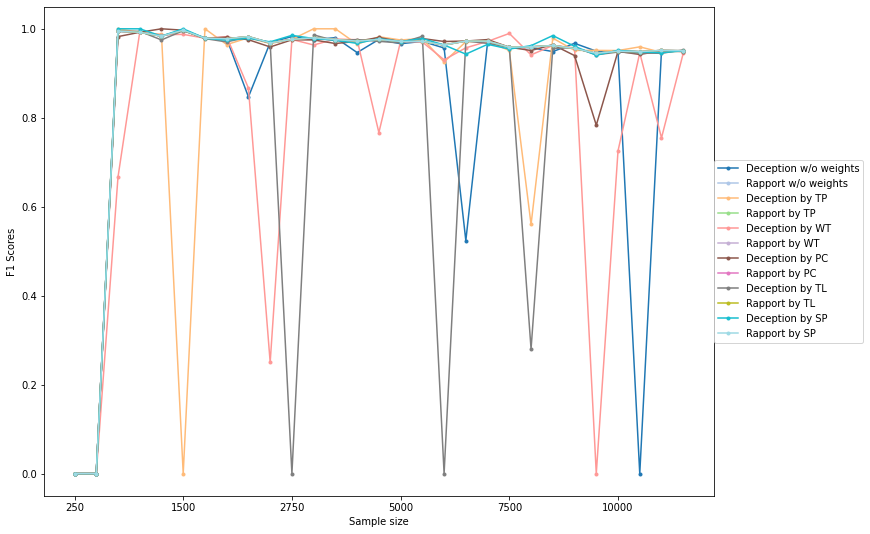

In [23]:
plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
plot.set_xlabel('Sample size', size=10)
plot.set_ylabel('F1 Scores', size=10)
lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
plot = plot.get_figure()
plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')